In [16]:
import patsy
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
#plt.style.available
#https://people.duke.edu/~ccc14/sta-663/PyMC3.html

In [3]:
plt.style.use("seaborn")

In [4]:
mtcars = pd.read_csv("../mtcars.csv", index_col = 0)

In [5]:
mtcars.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [6]:
from pymc3.glm import glm

In [6]:
?glm

In [ ]:
?pm.glm.glm

In [8]:
with pm.Model() as model_glm:
    glm(formula = 'am ~ mpg + wt', data =  mtcars, family = pm.glm.families.Binomial() )
    trace = pm.sample(100000)

C:\ProgramData\Miniconda3\lib\site-packages\theano\tensor\basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -58.73: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [00:22<00:00, 9021.61it/s]
Finished [100%]: Average ELBO = -58.576
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [10:41<00:00, 155.88it/s]


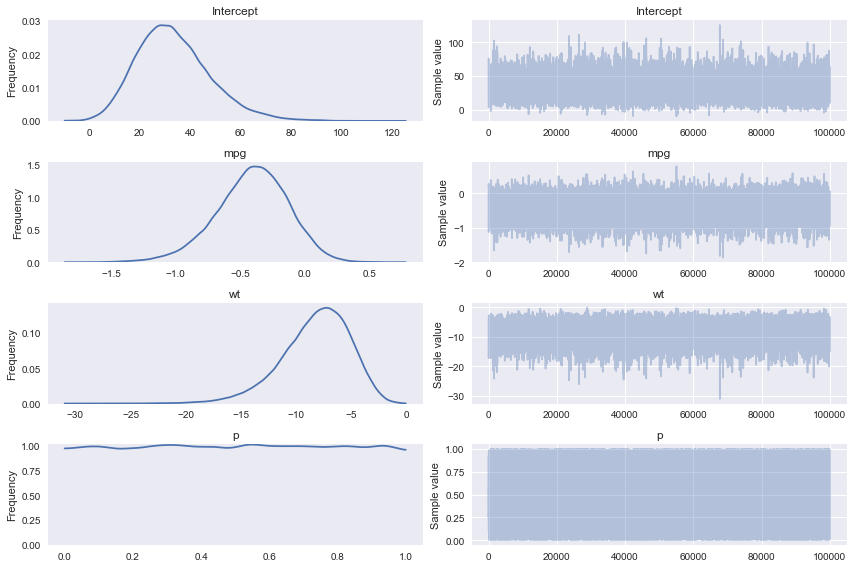

In [9]:
pm.traceplot(trace);
plt.show()

In [10]:
pm.summary(trace=trace)


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  33.502           14.578           0.173            [6.020, 62.090]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  9.100          23.253         32.084         42.137         66.404


mpg:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.409           0.281            0.003            [-0.976, 0.124]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.009         -0.583         -0.394         -0.217         0.099


wt:

  Mean             SD               MC Error         95% HPD interval
  -----------------------

In [11]:
coeff = pm.df_summary(trace =trace, alpha=0.97)
coeff['mean']
#Intercept    33.661031
#mpg          -0.410966
#wt           -8.370135
#p             0.499229
#Name: mean, dtype: float64

Intercept    33.502255
mpg          -0.408801
wt           -8.334838
p             0.500507
Name: mean, dtype: float64

In [12]:
hpdCI = pm.stats.hpd(pymc3_obj=trace)
print("Coefficient: [2.5%, 97.5%]")
for k, vals in hpdCI.items():
    print(f"{k}: {vals}")

Coefficient: [2.5%, 97.5%]
Intercept: [  6.01983458  62.08961721]
mpg: [-0.9757567   0.12444994]
wt: [-14.61959421  -2.84155067]
p_logodds_: [-3.61346667  3.62807163]
p: [ 0.01957417  0.9669318 ]


In [13]:
model = 'am ~ mpg + wt'
def predict(trace, formula, data):
    summary = pm.df_summary(trace = trace, alpha = 0.05)
    coeff = summary['mean'][:-1]
    y, x = patsy.dmatrices(data=data, formula_like=formula)
    x = x.dot(coeff)
    probs = np.exp(x) / (1 + np.exp(x))
    return probs
    
    
    

In [19]:
pm.stats.bpic(model=model_glm, trace=trace) ## predictive BIC

121.04870855395677

In [20]:
pred = predict(trace = trace, formula = model, data = mtcars)

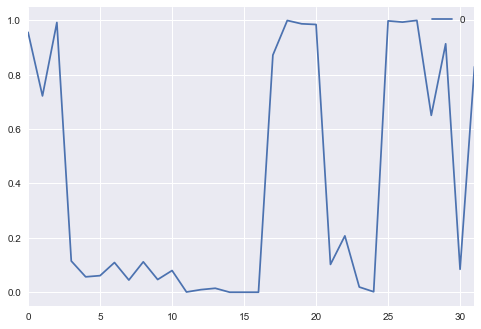

In [23]:
pred = pd.DataFrame(pred)
pred.plot()
plt.show()

In [25]:
designmatrix = patsy.dmatrix("mpg + wt", data = mtcars)

In [59]:
di = designmatrix.design_info
print(di)

DesignInfo(['Intercept', 'mpg', 'wt'],
           factor_infos={EvalFactor('mpg'): FactorInfo(factor=EvalFactor('mpg'),
                                    type='numerical',
                                    state=<factor state>,
                                    num_columns=1),
                         EvalFactor('wt'): FactorInfo(factor=EvalFactor('wt'),
                                    type='numerical',
                                    state=<factor state>,
                                    num_columns=1)},
           term_codings=OrderedDict([(Term([]),
                                      [SubtermInfo(factors=(),
                                                   contrast_matrices={},
                                                   num_columns=1)]),
                                     (Term([EvalFactor('mpg')]),
                                      [SubtermInfo(factors=(EvalFactor('mpg'),),
                                                   contrast_matrices={},


In [27]:
est = coeff['mean'][:-1]
est

Intercept    33.502255
mpg          -0.408801
wt           -8.334838
Name: mean, dtype: float64